In [1]:
import os
from scipy.signal import detrend
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces2 = cat["ECCO_layers"].to_dask()
ds_faces=xr.merge((ds_faces1,ds_faces2))

/srv/conda/envs/notebook/lib/python3.7/site-packages/fsspec/implementations/local.py:32: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [3]:
import gcsfs
basins = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-data/ECCO_basins.zarr')
                      , consolidated=True)


In [4]:
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins.basin_mask == 2,0)+ mask_2d.where(basins.basin_mask == 7,0)
              + mask_2d.where(basins.basin_mask == 9,0)
             + mask_2d.where(basins.basin_mask == 10,0)
             + mask_2d.where(basins.basin_mask == 12,0)
             + mask_2d.where(basins.basin_mask == 18,0)
             + mask_2d.where(basins.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))

basins2=basins.rename({'j':'j_g'})
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins2.basin_mask == 2,0)+ mask_2d.where(basins2.basin_mask == 7,0)
              + mask_2d.where(basins2.basin_mask == 9,0)
             + mask_2d.where(basins2.basin_mask == 10,0)
             + mask_2d.where(basins2.basin_mask == 12,0)
             + mask_2d.where(basins2.basin_mask == 18,0)
             + mask_2d.where(basins2.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))

basins3=basins.rename({'i':'i_g'})
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins3.basin_mask == 2,0)+ mask_2d.where(basins3.basin_mask == 7,0)
              + mask_2d.where(basins3.basin_mask == 9,0)
             + mask_2d.where(basins3.basin_mask == 10,0)
             + mask_2d.where(basins3.basin_mask == 12,0)
             + mask_2d.where(basins3.basin_mask == 18,0)
             + mask_2d.where(basins3.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [5]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [6]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [7]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
THETA_jg = grid.interp(ds.THETA, axis = 'Y')

In [8]:
from dask.distributed import Client

client = Client("tcp://10.32.17.11:41951")
client

Client Scheduler: tcp://10.32.17.11:41951 Dashboard: /user/0000-0002-2584-2760/proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 46.00 GB


In [9]:
latchoice=219

In [10]:
#Makes array of total volume transport above sigma=102 in the basin as a function of time
tr = (ds.LaVH3RHO[:].chunk({'time':12}).rolling(time=12).mean() * coords.dxG * ds.atl_maskS)[:, :101, latchoice, :].sum('l3_c') #at j_g = 215, up to sigma = 102
volume_over_time = tr.sum('i') 

In [11]:
#Makes array of i-star at each time 
volume_over_i = tr.cumsum('i')[:, 110:300] - volume_over_time 
istar_over_time = np.argmax((volume_over_i>0)[:, :],axis=1) #largest, time dimension
mask=(istar_over_time.values==0)
istar1 = istar_over_time + 110

In [12]:
istar1.load()

<xarray.DataArray (time: 288)>
array([110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 187, 186,
       186, 187, 187, 187, 187, 186, 187, 186, 187, 187, 187, 186, 186,
       185, 185, 185, 185, 176, 175, 175, 174, 174, 174, 175, 175, 175,
       175, 176, 176, 186, 186, 186, 186, 186, 187, 187, 188, 188, 188,
       189, 189, 189, 189, 190, 190, 189, 190, 190, 190, 190, 190, 190,
       190, 190, 190, 190, 190, 191, 191, 190, 192, 209, 192, 192, 191,
       192, 192, 191, 190, 190, 189, 189, 188, 188, 188, 187, 187, 187,
       187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
       187, 186, 186, 186, 187, 187, 187, 187, 187, 188, 188, 188, 188,
       189, 189, 190, 190, 190, 189, 189, 189, 189, 189, 189, 189, 189,
       189, 189, 189, 189, 189, 190, 191, 192, 193, 194, 194, 194, 194,
       194, 194, 195, 194, 193, 192, 192, 191, 191, 190, 190, 190, 189,
       189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189,
       189, 189, 189, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188,
       188, 188, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
       187, 188, 188, 188, 188, 188, 187, 187, 187, 187, 186, 186, 186,
       185, 186, 186, 186, 176, 186, 175, 187, 187, 188, 188, 189, 189,
       189, 189, 189, 189, 189, 190, 190, 190, 189, 189, 189, 189, 189,
       189, 189, 189, 188, 189, 188, 187, 188, 187, 187, 187, 187, 187,
       187, 187, 188, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188,
       188, 188, 188, 188, 188, 188, 188, 187, 187, 188, 188, 188, 188,
       188, 188, 188, 188, 188, 188, 187, 187, 187, 187, 187, 187, 187,
       187, 187])
Coordinates:
    j_g      int64 219
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


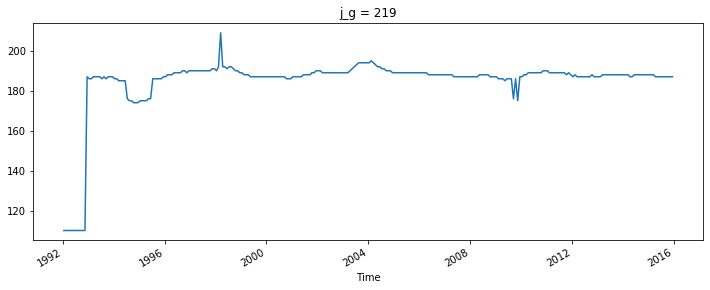

In [13]:
istar1.plot(figsize=(12,4))

In [14]:
#Ensure that the total volume at istar is the total volume on top of the band 
#volume at istar
volume_at_istar = tr.where(tr.i < istar1).sum('i')

In [15]:
#Sigma is 101 and j_g is 210
rho0=1029 
cp=3994
a = (ds.LaAy3RHO * ds.atl_maskS * rho0 * cp)[:, :, latchoice, :] #(time, l3_c, i)

In [16]:
#top left and right
adv1 = a.where(a.i < istar1)
top_left = adv1[:, :101, :].sum(['i','l3_c'])

adv2 = a.where(a.i >= istar1)
top_right = adv2[:, :101, :].sum(['i','l3_c'])

bottom = a[:, 101:, :].sum(['l3_c', 'i'])

istar3 = istar1 + 1
nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 
ratio=ratio.where(difference.values!=0,0)

In [17]:
#Compute the next cell's advection - top left  
adv_nextcell = a.where(a.i < istar3)[:, :101, :].sum(['i','l3_c'])
adv_difference = adv_nextcell - top_left 
adv_topleft = ((ratio * adv_difference + top_left)[12:]*ds.dt[12:]).cumsum('time')#ratio * adv_difference + 

In [18]:
#top right 
adv_nextcell = a.where(a.i >= istar3)[:, :101, :].sum(['i','l3_c']) 
#adv_difference = adv_nextcell - top_right
adv_topright = (((1-ratio) * adv_difference +adv_nextcell)[12:] * ds.dt[12:]).cumsum('time')#

In [19]:
a[:, :101, :].sum(['i','l3_c'])[73].values

array(9.49503439e+14)

In [20]:
#bottom
bottom = ((a[:, 101:, :].sum(['l3_c', 'i']))[12:] * ds.dt[12:]).cumsum('time')

In [21]:
tot_adv=((a.sum(['l3_c', 'i']))[12:] * ds.dt[12:]).cumsum('time')

In [22]:
#Load
adv_topright.load()

<xarray.DataArray (time: 276)>
array([-1.33172131e+19,  2.59564667e+20,  3.47832931e+20,  9.10879918e+19,
        3.41564518e+20,  3.39659779e+20,  1.52723904e+20,  1.39565458e+20,
       -1.03363948e+20,  1.62317053e+20,  3.98336081e+19, -4.45727859e+20,
       -1.06646774e+21, -1.20598016e+21, -1.34830574e+21, -1.32236268e+21,
       -1.16965709e+21, -1.02809304e+21, -1.33565310e+21, -1.35865514e+21,
       -1.27292544e+21, -1.09269221e+21, -1.06280951e+21, -1.17031941e+21,
       -1.40439161e+21, -1.72416136e+21, -1.64245967e+21, -1.06168398e+21,
       -8.55166179e+20, -3.50547013e+20, -4.19110031e+20, -3.75271664e+20,
       -5.72461922e+20, -4.94082646e+20, -8.27461309e+19,  2.87095336e+20,
        6.31790593e+20,  5.20191399e+20,  8.35702991e+20,  1.05955029e+21,
        1.24701674e+21,  1.21167159e+21,  1.01181145e+21,  8.16829339e+20,
        6.41866466e+20,  3.77426160e+20, -3.33419129e+18,  4.67122086e+20,
        9.43177616e+20,  7.05870341e+20,  6.69110208e+20,  7.95931082e+20,
        8.25704994e+20,  8.69253189e+20,  5.94810535e+20,  2.92177041e+20,
        2.20792058e+20,  2.75348001e+20,  1.44985300e+20,  3.09676369e+20,
        4.68458399e+20,  7.30056789e+20,  7.31363681e+20,  5.36693461e+20,
        4.86457232e+20,  3.57262031e+20,  5.28060607e+19, -2.15632885e+20,
       -5.76101732e+20, -9.63643281e+20, -1.24080973e+21, -1.70857161e+21,
       -1.96844164e+21, -2.22816093e+21, -2.35009655e+21, -2.63269762e+21,
       -2.56246219e+21, -2.67365703e+21, -2.80054153e+21, -2.96237728e+21,
       -3.28336648e+21, -3.51513857e+21, -3.46666024e+21, -3.80805473e+21,
       -3.65593112e+21, -3.97440351e+21, -3.84175168e+21, -3.76169029e+21,
       -3.76962598e+21, -3.88356747e+21, -3.89999444e+21, -3.93003549e+21,
       -4.04443539e+21, -4.53881482e+21, -4.79458525e+21, -4.66843316e+21,
       -4.48909402e+21, -4.15939217e+21, -3.73001990e+21, -3.61470365e+21,
       -3.25501248e+21, -3.01862525e+21, -3.09648389e+21, -3.05196163e+21,
       -2.82967671e+21, -2.90936253e+21, -3.04716681e+21, -2.55636184e+21,
       -2.66281287e+21, -2.79771903e+21, -2.71216671e+21, -2.80916383e+21,
       -3.05057248e+21, -3.26991221e+21, -3.53849170e+21, -3.68241603e+21,
       -3.41513968e+21, -3.18876180e+21, -3.48360067e+21, -3.15460904e+21,
       -3.14008240e+21, -3.19664298e+21, -2.84421192e+21, -2.41970150e+21,
       -2.38889419e+21, -2.36329172e+21, -2.51565557e+21, -2.58421962e+21,
       -2.66231228e+21, -2.64508305e+21, -2.71522080e+21, -2.68145274e+21,
       -2.80376595e+21, -2.58899099e+21, -2.59247120e+21, -2.70433098e+21,
       -2.79355069e+21, -2.82361865e+21, -3.02310277e+21, -3.20424885e+21,
       -3.41302169e+21, -3.47983585e+21, -3.50374089e+21, -3.78845525e+21,
       -3.94673126e+21, -4.01154995e+21, -3.57195914e+21, -3.54549778e+21,
       -3.44573110e+21, -3.41694588e+21, -3.54674999e+21, -3.71260515e+21,
       -4.01645480e+21, -4.02009579e+21, -4.10010136e+21, -4.17458689e+21,
       -4.41538897e+21, -4.56198228e+21, -4.50347421e+21, -4.35136597e+21,
       -4.43705777e+21, -4.40804217e+21, -4.54899697e+21, -4.77932584e+21,
       -5.14250758e+21, -5.06575979e+21, -4.98040743e+21, -5.31638071e+21,
       -5.54534937e+21, -5.86355362e+21, -6.21604219e+21, -6.22606338e+21,
       -6.57035730e+21, -6.59326412e+21, -6.82120766e+21, -6.94396500e+21,
       -6.87443969e+21, -6.67585323e+21, -6.22598523e+21, -6.34401437e+21,
       -6.62216884e+21, -6.28530960e+21, -6.53083438e+21, -6.27096705e+21,
       -6.17675311e+21, -6.26468765e+21, -6.51004306e+21, -6.85378807e+21,
       -6.84214129e+21, -7.21980523e+21, -7.33741391e+21, -7.65411585e+21,
       -8.18346544e+21, -8.11659985e+21, -8.19634251e+21, -8.41984972e+21,
       -8.41341157e+21, -8.15556747e+21, -8.16171431e+21, -8.27796229e+21,
       -7.95116655e+21, -7.57133275e+21, -8.16514719e+21, -7.49257256e+21,
       -7.08233096e+21, -6.60956528e+21, -6.05754258e+21, -5.75834796e+21,
       -5.80474583e+21, -6.05913706e+21, -6.43044348e+21, -6.64102962

In [23]:
adv_topleft.load()

<xarray.DataArray (time: 276)>
array([1.63251701e+21, 3.33195572e+21, 5.12466952e+21, 6.81728961e+21,
       8.62984242e+21, 1.03829907e+22, 1.25562618e+22, 1.46967415e+22,
       1.65359082e+22, 1.85825754e+22, 2.03756414e+22, 2.24327095e+22,
       2.42526358e+22, 2.55717276e+22, 2.73045032e+22, 2.90567256e+22,
       3.06769843e+22, 3.24738879e+22, 3.44757732e+22, 3.64306687e+22,
       3.83907913e+22, 4.02268443e+22, 4.18569705e+22, 4.36469383e+22,
       4.54197580e+22, 4.70226135e+22, 4.88224777e+22, 5.03979026e+22,
       5.21222981e+22, 5.39060539e+22, 5.59749891e+22, 5.81884895e+22,
       6.04256437e+22, 6.25536416e+22, 6.44520934e+22, 6.63727221e+22,
       6.76331272e+22, 6.96252846e+22, 7.17606914e+22, 7.37537917e+22,
       7.59254396e+22, 7.79819617e+22, 8.03136768e+22, 8.26532816e+22,
       8.48586078e+22, 8.71039346e+22, 8.94329725e+22, 9.14615434e+22,
       9.33870773e+22, 9.48067740e+22, 9.69353303e+22, 9.90590362e+22,
       1.01203670e+23, 1.03395255e+23, 1.05620592e+23, 1.07847106e+23,
       1.10221233e+23, 1.12583152e+23, 1.14128909e+23, 1.15916661e+23,
       1.17580118e+23, 1.19615559e+23, 1.21881373e+23, 1.23714029e+23,
       1.26041247e+23, 1.28100106e+23, 1.30366315e+23, 1.32719939e+23,
       1.34825795e+23, 1.37276584e+23, 1.39571956e+23, 1.41301867e+23,
       1.43251118e+23, 1.45367949e+23, 1.47653925e+23, 1.49710363e+23,
       1.51725316e+23, 1.53811791e+23, 1.55871873e+23, 1.57985976e+23,
       1.60026077e+23, 1.61814568e+23, 1.63928008e+23, 1.66152210e+23,
       1.68359345e+23, 1.70248834e+23, 1.72460717e+23, 1.74349955e+23,
       1.76388626e+23, 1.78345895e+23, 1.80593390e+23, 1.82759427e+23,
       1.84812677e+23, 1.87026066e+23, 1.89236640e+23, 1.90309683e+23,
       1.91702196e+23, 1.93106657e+23, 1.94546065e+23, 1.96235724e+23,
       1.98033098e+23, 1.99801548e+23, 2.01677389e+23, 2.03632492e+23,
       2.05846030e+23, 2.07776040e+23, 2.10438078e+23, 2.12786737e+23,
       2.14359749e+23, 2.15969579e+23, 2.17748467e+23, 2.19596979e+23,
       2.21425076e+23, 2.23391145e+23, 2.25643579e+23, 2.27957923e+23,
       2.29987983e+23, 2.31869200e+23, 2.33515654e+23, 2.35188236e+23,
       2.36933239e+23, 2.38362010e+23, 2.39951407e+23, 2.41616699e+23,
       2.43478623e+23, 2.45228678e+23, 2.47327528e+23, 2.49568076e+23,
       2.51915888e+23, 2.54345164e+23, 2.56138465e+23, 2.58558755e+23,
       2.60517270e+23, 2.62628581e+23, 2.64449428e+23, 2.66509362e+23,
       2.68785427e+23, 2.70867992e+23, 2.73209475e+23, 2.75285772e+23,
       2.77537878e+23, 2.80137099e+23, 2.82593112e+23, 2.84994191e+23,
       2.87296448e+23, 2.89640646e+23, 2.91669249e+23, 2.93641604e+23,
       2.95708220e+23, 2.97680780e+23, 2.99993809e+23, 3.02366642e+23,
       3.04585487e+23, 3.06511097e+23, 3.08665020e+23, 3.11075082e+23,
       3.13153536e+23, 3.14986270e+23, 3.16970115e+23, 3.19199405e+23,
       3.21230202e+23, 3.23326809e+23, 3.25436778e+23, 3.27884785e+23,
       3.29978033e+23, 3.32072673e+23, 3.34003087e+23, 3.35792135e+23,
       3.37877012e+23, 3.39402978e+23, 3.41418512e+23, 3.43430153e+23,
       3.45431049e+23, 3.47280014e+23, 3.49210216e+23, 3.51445977e+23,
       3.53684030e+23, 3.55596738e+23, 3.57633748e+23, 3.59391186e+23,
       3.61087069e+23, 3.62693985e+23, 3.64693730e+23, 3.66382044e+23,
       3.68217095e+23, 3.70198437e+23, 3.72264095e+23, 3.74365115e+23,
       3.76596234e+23, 3.78946542e+23, 3.81292902e+23, 3.83461082e+23,
       3.85094818e+23, 3.86605745e+23, 3.88525086e+23, 3.90228993e+23,
       3.92090751e+23, 3.93853746e+23, 3.95671785e+23, 3.97526036e+23,
       3.99324808e+23, 4.00917741e+23, 4.02656762e+23, 4.04339914e+23,
       4.05971271e+23, 4.07470186e+23, 4.09249755e+23, 4.11209079e+23,
       4.13312916e+23, 4.15350168e+23, 4.17632454e+23, 4.20134706e+23,
       4.22186187e+23, 4.24150531e+23, 4.26582022e+23, 4.29175179e+23,
       4.31241008e+23, 4.32603579e+23, 4.34596215e+23, 4.36396931e+23,
       4.38428172e+23, 4.40482361e+23, 4.42556363e+23, 4.4470560

In [24]:
bottom.load()

<xarray.DataArray (time: 276)>
array([-5.72895014e+20, -1.23969272e+21, -1.86946875e+21, -2.47698343e+21,
       -3.20694386e+21, -3.86302785e+21, -4.56835195e+21, -5.26095440e+21,
       -5.86452512e+21, -6.59869240e+21, -7.15058281e+21, -7.72239442e+21,
       -8.23900110e+21, -8.70967149e+21, -9.30525750e+21, -9.94569857e+21,
       -1.06131421e+22, -1.13056402e+22, -1.19788501e+22, -1.26809015e+22,
       -1.33236654e+22, -1.39694453e+22, -1.45251697e+22, -1.51066588e+22,
       -1.56971080e+22, -1.62060635e+22, -1.68820795e+22, -1.75935487e+22,
       -1.83394570e+22, -1.90937172e+22, -1.98269484e+22, -2.05600651e+22,
       -2.12656959e+22, -2.19854522e+22, -2.27059299e+22, -2.34051532e+22,
       -2.39848860e+22, -2.46265016e+22, -2.54016632e+22, -2.61119997e+22,
       -2.68778442e+22, -2.75577196e+22, -2.82717864e+22, -2.90005496e+22,
       -2.96461001e+22, -3.03101612e+22, -3.09710516e+22, -3.16757043e+22,
       -3.23489343e+22, -3.28092647e+22, -3.35115239e+22, -3.42300004e+22,
       -3.50167143e+22, -3.57920722e+22, -3.65155210e+22, -3.72130954e+22,
       -3.79280116e+22, -3.86739379e+22, -3.92385900e+22, -3.98550389e+22,
       -4.04612390e+22, -4.11758004e+22, -4.19307496e+22, -4.25737271e+22,
       -4.33266412e+22, -4.40211368e+22, -4.47268634e+22, -4.54211791e+22,
       -4.60864285e+22, -4.68005439e+22, -4.74734189e+22, -4.79920901e+22,
       -4.85636948e+22, -4.92132584e+22, -4.99320973e+22, -5.05601071e+22,
       -5.12502622e+22, -5.19266461e+22, -5.26207088e+22, -5.33285168e+22,
       -5.39256493e+22, -5.44983006e+22, -5.51517166e+22, -5.57469436e+22,
       -5.64289838e+22, -5.69980500e+22, -5.77412896e+22, -5.84002991e+22,
       -5.91078156e+22, -5.97709883e+22, -6.04926598e+22, -6.12042636e+22,
       -6.18596568e+22, -6.24688133e+22, -6.31182715e+22, -6.36307564e+22,
       -6.41835493e+22, -6.48098613e+22, -6.54302572e+22, -6.60953298e+22,
       -6.68051181e+22, -6.74766247e+22, -6.81456220e+22, -6.87975180e+22,
       -6.94915205e+22, -7.01127527e+22, -7.08748934e+22, -7.16169551e+22,
       -7.21385477e+22, -7.26963704e+22, -7.33975443e+22, -7.40538973e+22,
       -7.46751797e+22, -7.53050658e+22, -7.59703075e+22, -7.66286687e+22,
       -7.72804222e+22, -7.79175454e+22, -7.84198467e+22, -7.90259264e+22,
       -7.96585936e+22, -8.01135042e+22, -8.07713274e+22, -8.14872768e+22,
       -8.21888807e+22, -8.28342150e+22, -8.35033598e+22, -8.41787878e+22,
       -8.48572670e+22, -8.55923818e+22, -8.61672082e+22, -8.68873921e+22,
       -8.75019445e+22, -8.81992074e+22, -8.88569521e+22, -8.95569301e+22,
       -9.03216395e+22, -9.10383071e+22, -9.17677161e+22, -9.24764080e+22,
       -9.31420872e+22, -9.38994472e+22, -9.46467855e+22, -9.53219949e+22,
       -9.60309029e+22, -9.67423151e+22, -9.74850573e+22, -9.81846021e+22,
       -9.89419823e+22, -9.96560483e+22, -1.00405455e+23, -1.01157679e+23,
       -1.01858692e+23, -1.02492801e+23, -1.03176087e+23, -1.03863100e+23,
       -1.04464986e+23, -1.05071190e+23, -1.05786195e+23, -1.06563247e+23,
       -1.07279700e+23, -1.07981347e+23, -1.08695109e+23, -1.09439958e+23,
       -1.10077099e+23, -1.10791577e+23, -1.11429010e+23, -1.11974308e+23,
       -1.12611547e+23, -1.13147860e+23, -1.13771710e+23, -1.14475013e+23,
       -1.15127293e+23, -1.15806797e+23, -1.16478620e+23, -1.17201074e+23,
       -1.17918735e+23, -1.18598810e+23, -1.19332417e+23, -1.19942124e+23,
       -1.20499353e+23, -1.21097176e+23, -1.21750739e+23, -1.22434699e+23,
       -1.23132412e+23, -1.23817857e+23, -1.24499914e+23, -1.25163169e+23,
       -1.25831206e+23, -1.26470997e+23, -1.27146610e+23, -1.27756310e+23,
       -1.28213793e+23, -1.28783589e+23, -1.29448894e+23, -1.30048698e+23,
       -1.30725276e+23, -1.31413401e+23, -1.32113668e+23, -1.32740536e+23,
       -1.33370587e+23, -1.34018147e+23, -1.34489477e+23, -1.35187739e+23,
       -1.35856068e+23, -1.36478645e+23, -1.37232211e+23, -1.37980184e+23,
       -1.38721636e+23, -1.39437848e+23, -1.40144360e+23, -1.40896379

In [25]:
#detrending
right_detrend = xr.apply_ufunc(detrend, adv_topright.load().fillna(0),kwargs={'axis': 0}).where(~adv_topright.isnull())
left_detrend= xr.apply_ufunc(detrend, adv_topleft.load().fillna(0),kwargs={'axis': 0}).where(~adv_topleft.isnull())
bottom_detrend = xr.apply_ufunc(detrend, bottom.load().fillna(0),kwargs={'axis': 0}).where(~bottom.isnull())
totadv_detrend = xr.apply_ufunc(detrend, tot_adv.load().fillna(0),kwargs={'axis': 0}).where(~bottom.isnull())

#remove season
#Removing seasons 
right_month = right_detrend.groupby('time.month').mean('time')
left_month = left_detrend.groupby('time.month').mean('time')
bottom_month = bottom_detrend.groupby('time.month').mean('time')
totadv_month = totadv_detrend.groupby('time.month').mean('time')

right_ds = right_detrend.groupby('time.month') - right_month
left_ds = left_detrend.groupby('time.month') - left_month
bottom_ds = bottom_detrend.groupby('time.month') - bottom_month
totadv_ds=totadv_detrend.groupby('time.month') - totadv_month

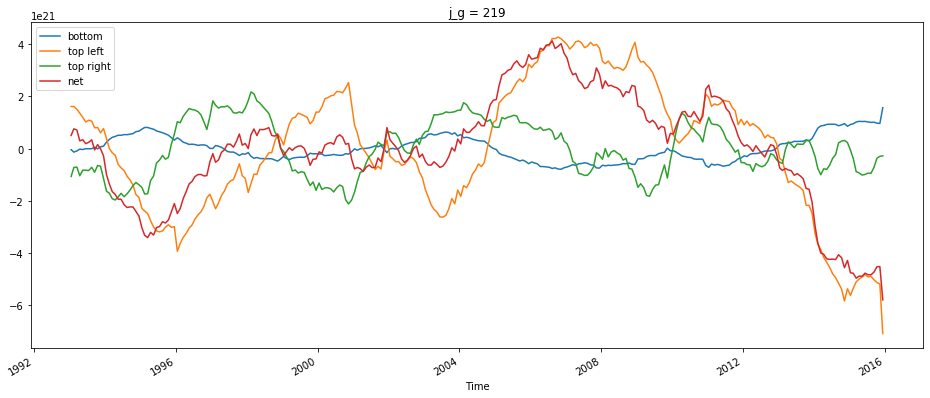

In [26]:
#detrend, mean removed
net = bottom_ds + left_ds+ right_ds
fig, ax = pltt.subplots(figsize=(16,6))
(bottom_ds).plot(ax=ax)
(left_ds).plot(ax=ax)
(right_ds).plot(ax=ax)
(net).plot(ax=ax)
#totadv_ds.plot(ax=ax)
ax.legend(("bottom", "top left", "top right", "net"),loc='upper left')

In [27]:
#Piecuch's throughflow 

v = (ds.VVELMASS[:, :, latchoice, :] * coords.drF * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :]).sum(['i','k'])
t = (THETA_jg[:, :, latchoice, :] * coords.drF * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :]).sum(['i','k'])
a = (coords.drF * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :] * coords.hFacS[:, latchoice, :]).sum(['i','k'])
p_throughflow = (v[12:]*t[12:]*ds.dt[12:]).cumsum('time') / a #has units of degCm^3/s- should i do a minus (v*t[time 0])? 
p_throughflow.load()

<xarray.DataArray (time: 276)>
array([-2.79291808e+13, -6.05402084e+13, -7.13214004e+13, -1.07268544e+14,
       -1.44211604e+14, -1.73938903e+14, -2.09276820e+14, -2.37468123e+14,
       -2.58000396e+14, -2.86661549e+14, -2.99071480e+14, -3.22520051e+14,
       -3.59686401e+14, -3.86253561e+14, -3.96720365e+14, -4.16067083e+14,
       -4.46563219e+14, -4.70591042e+14, -5.04535194e+14, -5.38155576e+14,
       -5.42599566e+14, -5.55385500e+14, -5.65838403e+14, -5.79418863e+14,
       -6.05611402e+14, -6.30078922e+14, -6.54007100e+14, -6.79669115e+14,
       -7.18758348e+14, -7.49825349e+14, -7.84956242e+14, -8.08557272e+14,
       -8.41495616e+14, -8.66204186e+14, -8.91159994e+14, -9.09910337e+14,
       -9.38640997e+14, -9.63356158e+14, -9.97270280e+14, -1.01604234e+15,
       -1.04689857e+15, -1.07231460e+15, -1.09973373e+15, -1.13327433e+15,
       -1.14580678e+15, -1.17377522e+15, -1.20653244e+15, -1.22283030e+15,
       -1.23602120e+15, -1.25629548e+15, -1.28179298e+15, -1.30203025e+15,
       -1.34469471e+15, -1.38252476e+15, -1.41220670e+15, -1.43871695e+15,
       -1.45402680e+15, -1.47153098e+15, -1.49819370e+15, -1.50913934e+15,
       -1.52992927e+15, -1.55570326e+15, -1.58246630e+15, -1.61409895e+15,
       -1.64328405e+15, -1.67682522e+15, -1.70715973e+15, -1.73003644e+15,
       -1.76119825e+15, -1.79116556e+15, -1.81873769e+15, -1.84064009e+15,
       -1.85356420e+15, -1.87554194e+15, -1.89560123e+15, -1.91776420e+15,
       -1.94236741e+15, -1.97040795e+15, -2.00815448e+15, -2.04573012e+15,
       -2.05575306e+15, -2.07068045e+15, -2.08657337e+15, -2.10203067e+15,
       -2.10789593e+15, -2.13803433e+15, -2.16453082e+15, -2.18530836e+15,
       -2.21429657e+15, -2.24106833e+15, -2.26483307e+15, -2.28915273e+15,
       -2.29973653e+15, -2.31054988e+15, -2.33793144e+15, -2.37545058e+15,
       -2.38345425e+15, -2.42688299e+15, -2.43793956e+15, -2.46371085e+15,
       -2.48258509e+15, -2.50577886e+15, -2.53094697e+15, -2.53954742e+15,
       -2.55466737e+15, -2.56126334e+15, -2.58235831e+15, -2.58536464e+15,
       -2.59406932e+15, -2.62141419e+15, -2.65787103e+15, -2.68614208e+15,
       -2.71211679e+15, -2.73341424e+15, -2.75199920e+15, -2.75955910e+15,
       -2.76409767e+15, -2.77101239e+15, -2.78525617e+15, -2.79892248e+15,
       -2.83391760e+15, -2.83445025e+15, -2.85905381e+15, -2.89026021e+15,
       -2.91967780e+15, -2.94723111e+15, -2.96222950e+15, -2.98011168e+15,
       -2.99384301e+15, -3.00834675e+15, -3.02311170e+15, -3.04330834e+15,
       -3.07784302e+15, -3.10268776e+15, -3.12594621e+15, -3.16245740e+15,
       -3.20032046e+15, -3.23287475e+15, -3.25899088e+15, -3.29468735e+15,
       -3.31275859e+15, -3.34229528e+15, -3.36979934e+15, -3.38756453e+15,
       -3.41936181e+15, -3.43284722e+15, -3.45788073e+15, -3.48466097e+15,
       -3.51488540e+15, -3.55294220e+15, -3.58660206e+15, -3.62002543e+15,
       -3.65533636e+15, -3.66901751e+15, -3.68161286e+15, -3.68328061e+15,
       -3.68875167e+15, -3.72040503e+15, -3.74696671e+15, -3.76518562e+15,
       -3.79495972e+15, -3.81715250e+15, -3.85018780e+15, -3.88002382e+15,
       -3.90166012e+15, -3.92875291e+15, -3.95031725e+15, -3.96795338e+15,
       -3.98935824e+15, -4.03151710e+15, -4.04159402e+15, -4.06469335e+15,
       -4.09492469e+15, -4.13190476e+15, -4.16497615e+15, -4.19910964e+15,
       -4.22922961e+15, -4.25135693e+15, -4.27498770e+15, -4.30825150e+15,
       -4.32991698e+15, -4.33762876e+15, -4.36156582e+15, -4.39176742e+15,
       -4.41684646e+15, -4.44372593e+15, -4.47612840e+15, -4.50555518e+15,
       -4.52175763e+15, -4.53260264e+15, -4.55773468e+15, -4.57653489e+15,
       -4.58419697e+15, -4.60901740e+15, -4.63714430e+15, -4.65939179e+15,
       -4.68802038e+15, -4.71968914e+15, -4.76753539e+15, -4.78688753e+15,
       -4.79453097e+15, -4.81939001e+15, -4.82855150e+15, -4.84375413e+15,
       -4.85716329e+15, -4.87495360e+15, -4.89268311e+15, -4.90814643e+15,
       -4.93993754e+15, -4.98198307e+15, -5.00805297e+15, -5.03804840

In [28]:
#Overturning
v = (ds.VVELMASS[:, :, latchoice, :] * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :]).sum('i')
t = (THETA_jg[:, :, latchoice, :] * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :]).sum('i')
a = (coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :] * coords.hFacS[:, latchoice, :]).sum('i')
ov1 = (((v * t * coords.drF)/a).sum('k'))[12:] * ds.dt[12:]
ov = ov1.cumsum('time')
p_overturning = ov - p_throughflow  #also has units of degCm^3/s
p_overturning.load()

<xarray.DataArray (time: 276)>
array([2.40006436e+14, 5.38576105e+14, 8.19513706e+14, 1.03072753e+15,
       1.31776628e+15, 1.55154926e+15, 1.83721228e+15, 2.13917600e+15,
       2.32450003e+15, 2.64535863e+15, 2.86287728e+15, 3.10478601e+15,
       3.31667578e+15, 3.49309556e+15, 3.75267705e+15, 4.02766363e+15,
       4.27447247e+15, 4.55291056e+15, 4.77702947e+15, 5.03715355e+15,
       5.30873184e+15, 5.56942338e+15, 5.77190034e+15, 6.00052681e+15,
       6.23133932e+15, 6.44477845e+15, 6.74035299e+15, 7.03476385e+15,
       7.28951788e+15, 7.61570724e+15, 7.88820486e+15, 8.21396978e+15,
       8.50340378e+15, 8.80525004e+15, 9.11217518e+15, 9.39212440e+15,
       9.58426486e+15, 9.87593895e+15, 1.02061153e+16, 1.04930079e+16,
       1.08027829e+16, 1.10736594e+16, 1.13758414e+16, 1.16713753e+16,
       1.19300746e+16, 1.21906963e+16, 1.24653015e+16, 1.28025274e+16,
       1.31153533e+16, 1.32894626e+16, 1.35777642e+16, 1.38656585e+16,
       1.41594556e+16, 1.44556095e+16, 1.47245903e+16, 1.49762437e+16,
       1.52951543e+16, 1.56006743e+16, 1.57477685e+16, 1.59753997e+16,
       1.62119353e+16, 1.65083956e+16, 1.68106943e+16, 1.70399168e+16,
       1.73530732e+16, 1.76040327e+16, 1.78716547e+16, 1.81598719e+16,
       1.83735382e+16, 1.86478929e+16, 1.89375542e+16, 1.91087844e+16,
       1.93741604e+16, 1.96435693e+16, 1.99738893e+16, 2.02190267e+16,
       2.04930146e+16, 2.07666544e+16, 2.10278749e+16, 2.12741622e+16,
       2.14742385e+16, 2.16471078e+16, 2.19570955e+16, 2.22213122e+16,
       2.25727899e+16, 2.28201584e+16, 2.31500063e+16, 2.34209625e+16,
       2.37083646e+16, 2.39667244e+16, 2.42851368e+16, 2.45890977e+16,
       2.48483186e+16, 2.50850476e+16, 2.53546075e+16, 2.54815277e+16,
       2.56719558e+16, 2.59057794e+16, 2.61430330e+16, 2.63953386e+16,
       2.66827285e+16, 2.69594530e+16, 2.72034624e+16, 2.74753403e+16,
       2.78220468e+16, 2.80448125e+16, 2.84056355e+16, 2.87899766e+16,
       2.89612070e+16, 2.91713035e+16, 2.94355471e+16, 2.96821525e+16,
       2.99052262e+16, 3.01508510e+16, 3.04352266e+16, 3.07429427e+16,
       3.10584990e+16, 3.13159985e+16, 3.14744883e+16, 3.17165076e+16,
       3.19623173e+16, 3.21648861e+16, 3.24249790e+16, 3.27001242e+16,
       3.29577007e+16, 3.31937673e+16, 3.34588494e+16, 3.37571175e+16,
       3.40667126e+16, 3.44152181e+16, 3.46377631e+16, 3.49729745e+16,
       3.52198580e+16, 3.55114185e+16, 3.57643268e+16, 3.60539354e+16,
       3.63639841e+16, 3.66462374e+16, 3.69537379e+16, 3.71894263e+16,
       3.74755392e+16, 3.78246452e+16, 3.81647020e+16, 3.84896666e+16,
       3.88118693e+16, 3.91417669e+16, 3.94610315e+16, 3.97433842e+16,
       4.00427181e+16, 4.03265391e+16, 4.06614258e+16, 4.09971027e+16,
       4.12708545e+16, 4.15172035e+16, 4.18145199e+16, 4.21565083e+16,
       4.24327402e+16, 4.26800148e+16, 4.29495512e+16, 4.32972398e+16,
       4.35711291e+16, 4.38839921e+16, 4.41649653e+16, 4.44904749e+16,
       4.47040117e+16, 4.49832100e+16, 4.52454517e+16, 4.54340401e+16,
       4.57021390e+16, 4.58718524e+16, 4.61258685e+16, 4.63908698e+16,
       4.66285972e+16, 4.68742993e+16, 4.71018429e+16, 4.74143378e+16,
       4.77650313e+16, 4.80519083e+16, 4.84186647e+16, 4.86553694e+16,
       4.88719367e+16, 4.91499972e+16, 4.94279959e+16, 4.97040409e+16,
       4.99727660e+16, 5.02420038e+16, 5.05083500e+16, 5.07603070e+16,
       5.11005017e+16, 5.13923034e+16, 5.17436403e+16, 5.20331656e+16,
       5.21957375e+16, 5.24229098e+16, 5.27073860e+16, 5.29323525e+16,
       5.32174325e+16, 5.35040908e+16, 5.37557096e+16, 5.39959029e+16,
       5.43119029e+16, 5.45655816e+16, 5.47215283e+16, 5.50562284e+16,
       5.53248375e+16, 5.55774215e+16, 5.58851015e+16, 5.61972781e+16,
       5.64878742e+16, 5.67487265e+16, 5.70331057e+16, 5.73817176e+16,
       5.76360360e+16, 5.78870679e+16, 5.81757777e+16, 5.86073727e+16,
       5.89164928e+16, 5.90636152e+16, 5.93514615e+16, 5.96269329e+16,
       5.99267588e+16, 6.02083812e+16, 6.04467659e+16, 6.0720168

In [29]:
#Gyre
tot1 = (ds.ADVy_TH[12:, :, latchoice, :] * ds.atl_maskS[latchoice, :]*ds.dt).sum(['i','k'])
tot = tot1.cumsum('time')
p_gyre = tot - p_overturning - p_throughflow
p_gyre.load()

<xarray.DataArray (time: 276)>
array([4.25088835e+13, 9.42090903e+13, 1.28495219e+14, 1.54784668e+14,
       2.29050465e+14, 2.91468310e+14, 3.52838018e+14, 4.28160402e+14,
       5.04903787e+14, 5.96708377e+14, 6.63799155e+14, 6.88584099e+14,
       6.79945436e+14, 7.02584072e+14, 6.95539058e+14, 7.16729598e+14,
       7.69411636e+14, 8.18169966e+14, 8.76452699e+14, 9.49191691e+14,
       1.02345635e+15, 1.10902096e+15, 1.18569034e+15, 1.23853102e+15,
       1.26465002e+15, 1.26403901e+15, 1.28572607e+15, 1.36850827e+15,
       1.44117812e+15, 1.51933532e+15, 1.59028812e+15, 1.65899628e+15,
       1.72716893e+15, 1.81175394e+15, 1.91649380e+15, 2.04247530e+15,
       2.12855659e+15, 2.16305571e+15, 2.27453688e+15, 2.37300379e+15,
       2.48175812e+15, 2.56266183e+15, 2.63287333e+15, 2.71538518e+15,
       2.80616910e+15, 2.89392453e+15, 2.96532285e+15, 3.08100103e+15,
       3.20191036e+15, 3.22376799e+15, 3.29906662e+15, 3.40418874e+15,
       3.49071004e+15, 3.58757788e+15, 3.64694124e+15, 3.72018250e+15,
       3.80293087e+15, 3.92139172e+15, 4.00796330e+15, 4.11635260e+15,
       4.19649456e+15, 4.31085668e+15, 4.40326315e+15, 4.44777989e+15,
       4.53464554e+15, 4.61776850e+15, 4.68609789e+15, 4.75918392e+15,
       4.83949894e+15, 4.92338260e+15, 4.98863899e+15, 5.02021496e+15,
       5.03974125e+15, 5.08613128e+15, 5.12751753e+15, 5.18334650e+15,
       5.27340165e+15, 5.34385013e+15, 5.42188285e+15, 5.51597340e+15,
       5.59892059e+15, 5.68042243e+15, 5.75337655e+15, 5.81791127e+15,
       5.88039957e+15, 5.90696442e+15, 5.99324881e+15, 6.06189044e+15,
       6.12544245e+15, 6.18100990e+15, 6.25362886e+15, 6.32057123e+15,
       6.38422532e+15, 6.42835973e+15, 6.50379833e+15, 6.58148758e+15,
       6.64702044e+15, 6.72618727e+15, 6.80374679e+15, 6.85457340e+15,
       6.93820877e+15, 7.00910414e+15, 7.06496795e+15, 7.12962040e+15,
       7.22185346e+15, 7.30474674e+15, 7.39377111e+15, 7.52277636e+15,
       7.59018033e+15, 7.63057825e+15, 7.68583758e+15, 7.73397801e+15,
       7.77178177e+15, 7.81920461e+15, 7.87425842e+15, 7.94202045e+15,
       8.03140708e+15, 8.13861795e+15, 8.20102722e+15, 8.31222572e+15,
       8.37559896e+15, 8.39675993e+15, 8.47369425e+15, 8.56404065e+15,
       8.62570656e+15, 8.69222334e+15, 8.75294186e+15, 8.83669780e+15,
       8.92801438e+15, 9.01042786e+15, 9.08206129e+15, 9.18893275e+15,
       9.27383594e+15, 9.40344530e+15, 9.45595477e+15, 9.50654427e+15,
       9.58039267e+15, 9.65572788e+15, 9.71805536e+15, 9.80675314e+15,
       9.87392239e+15, 9.98625769e+15, 1.00836433e+16, 1.01271057e+16,
       1.01858825e+16, 1.02509882e+16, 1.03765940e+16, 1.04371609e+16,
       1.05108903e+16, 1.05783474e+16, 1.06259976e+16, 1.06777156e+16,
       1.07346600e+16, 1.08153569e+16, 1.08690050e+16, 1.09298129e+16,
       1.09597383e+16, 1.10068878e+16, 1.10868838e+16, 1.11477839e+16,
       1.12026248e+16, 1.12584368e+16, 1.13159179e+16, 1.13786126e+16,
       1.14526410e+16, 1.15550302e+16, 1.16497282e+16, 1.16996572e+16,
       1.17494906e+16, 1.17853138e+16, 1.17942327e+16, 1.18682385e+16,
       1.19051155e+16, 1.19753744e+16, 1.20316293e+16, 1.20916175e+16,
       1.21579039e+16, 1.22414000e+16, 1.23248814e+16, 1.23719885e+16,
       1.23864650e+16, 1.24436146e+16, 1.24573655e+16, 1.25191336e+16,
       1.25751499e+16, 1.26267145e+16, 1.26697297e+16, 1.27133976e+16,
       1.27725693e+16, 1.28159236e+16, 1.28676288e+16, 1.28990534e+16,
       1.29015486e+16, 1.29444627e+16, 1.29738431e+16, 1.29853912e+16,
       1.30188845e+16, 1.30881716e+16, 1.31548801e+16, 1.32044001e+16,
       1.32599326e+16, 1.33535629e+16, 1.33707460e+16, 1.34545434e+16,
       1.35334878e+16, 1.36269585e+16, 1.37209739e+16, 1.37918067e+16,
       1.38532076e+16, 1.38939376e+16, 1.39286990e+16, 1.39847086e+16,
       1.40481280e+16, 1.41092752e+16, 1.41827406e+16, 1.43207715e+16,
       1.44159328e+16, 1.44388851e+16, 1.44976490e+16, 1.45313690e+16,
       1.45696995e+16, 1.46093087e+16, 1.46298313e+16, 1.4677473

In [30]:
#detrending - piecuch
tf_detrend = xr.apply_ufunc(detrend, p_throughflow.load().fillna(0),kwargs={'axis': 0}).where(~p_throughflow.isnull())
ov_detrend = xr.apply_ufunc(detrend, p_overturning.load().fillna(0),kwargs={'axis': 0}).where(~p_overturning.isnull())
gyre_detrend = xr.apply_ufunc(detrend, p_gyre.load().fillna(0),kwargs={'axis': 0}).where(~p_gyre.isnull())
tot_detrend = xr.apply_ufunc(detrend, tot.load().fillna(0),kwargs={'axis': 0}).where(~p_gyre.isnull())

In [31]:
#Removing seasons from detrended  - piecuch
month_tf = tf_detrend.groupby('time.month').mean('time')
month_ov = ov_detrend.groupby('time.month').mean('time')
month_gyre = gyre_detrend.groupby('time.month').mean('time')
month_tot = tot_detrend.groupby('time.month').mean('time')

tf_ds = tf_detrend.groupby('time.month') - month_tf
ov_ds = ov_detrend.groupby('time.month') - month_ov
gyre_ds = gyre_detrend.groupby('time.month') - month_gyre
tot_ds = tot_detrend.groupby('time.month') - month_tot
net = bottom_ds + left_ds+ right_ds

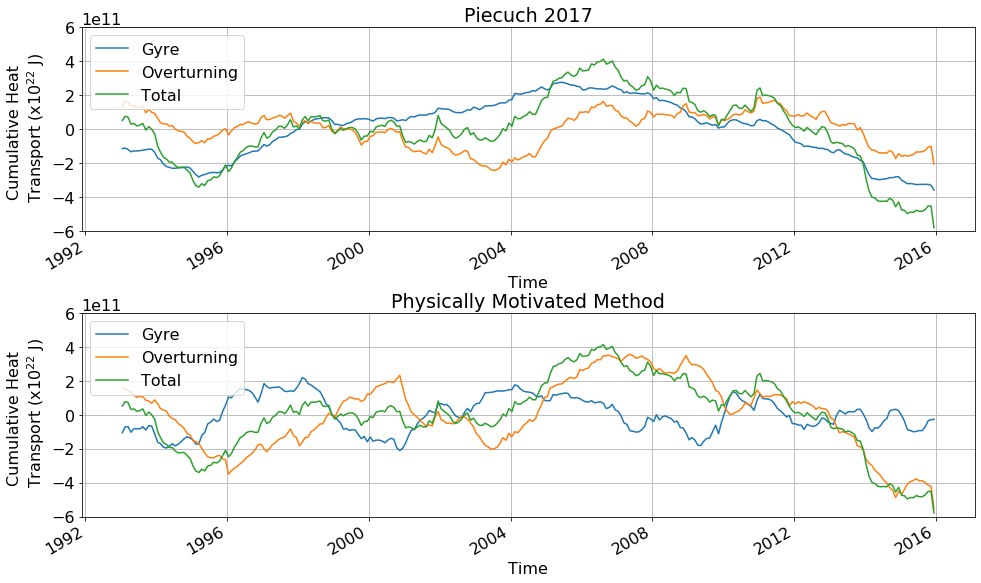

In [32]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
fig, ax = pltt.subplots(figsize=(16,9))
pltt.subplot(2, 1, 1)
(gyre_ds * rho0 * cp/10**10).plot()
(ov_ds* rho0 * cp/10**10).plot()
#(tf_ds * rho0 * cp/10**10).plot(ax=ax)
(tot_ds * rho0 * cp/10**10).plot()
pltt.ylim(-0.6*10**12,0.6*10**12)
pltt.grid(True)
pltt.legend(("Gyre", "Overturning", "Total"),loc='upper left')
pltt.ylabel('Cumulative Heat \n Transport (x$10^{22}$ J)')
pltt.title('Piecuch 2017')
pltt.subplot(2, 1, 2)
(right_ds/10**10).plot()
((bottom_ds+left_ds)/10**10).plot()
#().plot(ax=ax)
(net/10**10).plot()
pltt.ylim(-0.6*10**12,0.6*10**12)
pltt.legend(("Gyre","Overturning", "Total"),loc='upper left')
pltt.ylabel('Cumulative Heat \n Transport (x$10^{22}$ J)')
pltt.title('Physically Motivated Method')
pltt.grid(True)
fig=pltt.gcf()
fig.subplots_adjust(hspace=0.4)
fig.savefig('latitude_220.pdf', bbox_inches='tight')

In [31]:
coords.YC[220][0].values

array(45.06441, dtype=float32)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1025, in _reconnect
    await self._close()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures